based on https://www.kaggle.com/code/dota2player/next-word-prediction-with-lstm-pytorch/notebook

In [2]:
import random
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torchtext
import torchtext.vocab
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
torchtext.disable_torchtext_deprecation_warning()
warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
filename = 'fake_and_real_news_dataset.csv'

datapath = Path.cwd().parent / 'data' / filename
df = pd.read_csv(str(datapath))
col = 'title'

In [3]:
sentences = df[col]
sentences = sentences.dropna()
sentences = sentences.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

tokenizer = get_tokenizer('basic_english')
tokenized_sentences = [tokenizer(s) for s in sentences]

features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_sentences,
    min_freq=2, # minimum frequency of a word to be included in the vocabulary
    specials=['<pad>', '<oov>'], # pad = padding, oov = out of vocabulary
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_sentences,
    min_freq=2
)

print('feature vocab size', len(features_vocab))
print('target vocab size', len(target_vocab))
print('num <pad>', features_vocab['<pad>'])
print('num <oov>', features_vocab['<oov>'])

feature vocab size 3917
target vocab size 3915
num <pad> 0
num <oov> 1


In [4]:
def get_ngrams(tokenized_sentence):
    """
    ngrams: "hello beautiful world" -> ["hello", "hello beautiful", "hello beautiful world"]
    """
    list_ngrams = []
    for i in range(1, len(tokenized_sentence)):
        ngram_sequence = tokenized_sentence[:i+1]
        list_ngrams.append(ngram_sequence)
    return list_ngrams

def add_random_oov_tokens(ngram):
    """
    replace tokens in ngram with <oov> with 10% probability
    to improve generalizability of the model
    """
    for idx, _ in enumerate(ngram[:-1]):
        if random.uniform(0, 1) < 0.1:
            ngram[idx] = '<oov>'
    return ngram

def text_to_numerical_sequence(tokenized_sentence):
    """
    map string tokens to numerical tokens
    """
    tokens_list = []
    if tokenized_sentence[-1] in target_vocab.get_itos(): # get_itos() = get index to string
        for token in tokenized_sentence[:-1]:
            num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
            tokens_list.append(num_token)
        num_token = target_vocab[tokenized_sentence[-1]]
        tokens_list.append(num_token)
        return tokens_list
    return None

ngrams_list = []
for tokenized_sentence in tokenized_sentences:
    ngrams_list.extend(get_ngrams(tokenized_sentence))
print(len(ngrams_list))

ngrams_list_oov = []
for ngram in ngrams_list:
    ngrams_list_oov.append(add_random_oov_tokens(ngram))
print(any('<oov>' in ngram for ngram in ngrams_list_oov))

input_sequences = [text_to_numerical_sequence(sequence) for sequence in ngrams_list_oov if text_to_numerical_sequence(sequence)]
print(f'Total input sequences: {len(input_sequences)}')
print(input_sequences[7:9])

43562
True
Total input sequences: 39731
[[10, 1, 12, 1, 1068, 1, 2351, 1, 419, 21, 8], [1, 1244, 12, 1, 1068, 1, 2351, 149, 419, 21, 10, 1, 1]]


In [5]:
X = [sequence[:-1] for sequence in input_sequences] # type: ignore
y = [sequence[-1] for sequence in input_sequences] # type: ignore

len(X[0]), y[0]

(1, 1242)

In [6]:
longest_sequence_feature = max(len(sequence) for sequence in X)
padded_X = [F.pad(torch.tensor(sequence), (longest_sequence_feature - len(sequence), 0), value=0) for sequence in X]

longest_sequence_feature, padded_X[0], X[0], len(padded_X[0])

(40,
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0, 10]),
 [10],
 40)

In [7]:
padded_X = torch.stack(padded_X)
y = torch.tensor(y)

y_one_hot = one_hot(y, num_classes=len(target_vocab))

data = TensorDataset(padded_X, y_one_hot)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32
train_data, test_data = random_split(data, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [8]:
class My_LSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_LSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) 
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out[:, -1, :])
        return output


embedding_dim = longest_sequence_feature
hidden_dim = 200
epochs = 50
model = My_LSTM(len(features_vocab), len(target_vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)


def calculate_topk_accuracy(model, data_loader, k=3):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy


In [9]:
all_accuracies = []
all_losses = []
for epoch in range(epochs):   
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()
            
    if epoch % 5 == 0:
        accuracy = calculate_topk_accuracy(model, train_loader)
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())


Epoch 0/50, Loss: 7.5174, Train K-Accuracy: 11.05%
Epoch 5/50, Loss: 4.0144, Train K-Accuracy: 25.26%
Epoch 10/50, Loss: 3.5786, Train K-Accuracy: 49.39%
Epoch 15/50, Loss: 3.1848, Train K-Accuracy: 68.66%
Epoch 20/50, Loss: 2.9329, Train K-Accuracy: 78.31%
Epoch 25/50, Loss: 2.4009, Train K-Accuracy: 84.20%
Epoch 30/50, Loss: 2.0217, Train K-Accuracy: 87.25%
Epoch 35/50, Loss: 1.4438, Train K-Accuracy: 89.24%
Epoch 40/50, Loss: 4.0211, Train K-Accuracy: 90.44%
Epoch 45/50, Loss: 0.9907, Train K-Accuracy: 91.12%


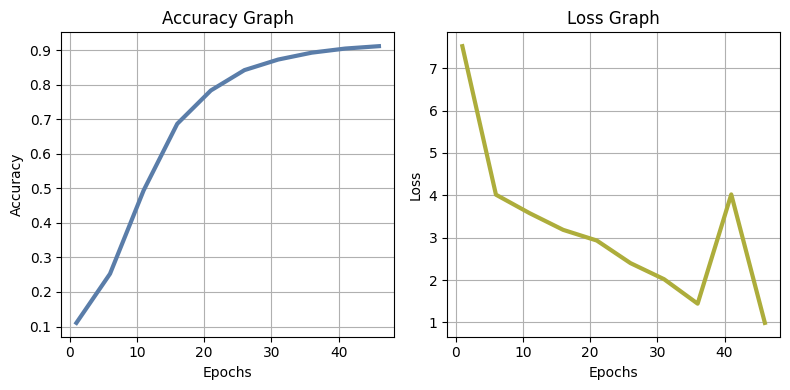

In [10]:
epoch_list = [i for i in range(1,epochs,5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) 

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)
 
axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [11]:
accuracy = calculate_topk_accuracy(model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')


Test K-Accuracy: 16.91%


In [12]:
def text_to_numerical_sequence_test(tokenized_text):
    tokens_list = []
    for token in tokenized_text:
        num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
        tokens_list.append(num_token)
    return tokens_list

def use_model(input_list):
    model.eval()
    output_list = []
    for data in input_test:
        sentence = data[0]
        num_words = data[1]
        for i in range(num_words):
            output_of_model = []
            tokenized_input_test = tokenizer(sentence)
            tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
            padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test), (longest_sequence_feature - len(tokenized_sequence_input_test)-1, 0), value=0)
            output_test_walking = torch.argmax(model(padded_tokenized_sequence_input_test.unsqueeze(0)))
            sentence = sentence + ' ' + target_vocab.lookup_token(output_test_walking.item()) # type: ignore
        output_list.append(sentence)
    return output_list

input_test = [['stand', 5], ['deep learning is', 5], ['data cleaning', 4], ['6 ways', 4], ['you did a', 2]]
outputs_model = use_model(input_test)
outputs_model


['stand s not who will be',
 'deep learning is getting worse everywhere down on',
 'data cleaning the republican presidential candidates',
 '6 ways to fix the world',
 'you did a good news']